# Interpretabilidad de Modelos con LIME
En este notebook utilizaremos LIME (Local Interpretable Model-agnostic Explanations) para explicar las predicciones de nuestros modelos de clasificación sobre instancias específicas del dataset de Churn.

In [11]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import scipy.sparse as sp
import lime
import lime.lime_tabular
import warnings

# Silenciar warnings para una salida más limpia
warnings.filterwarnings('ignore')

print("✓ Todas las librerías importadas correctamente")

✓ Todas las librerías importadas correctamente


## Cargar y Preparar Datos
Reutilizaremos la función de preprocesamiento del notebook de training.

In [12]:
# Función de preprocesamiento (copiada del notebook Training)
def prepare_pipeline_and_data(df_input, target_col='Churn', id_col='customerID'):
    """Construye un pipeline que realiza:
       - conversión de TotalCharges a numérico y eliminación de filas inválidas
       - imputación de TotalCharges si hace falta (mediana)
       - log-transform de TotalCharges
       - escalado de variables numéricas (tenure, MonthlyCharges, TotalCharges_log)
       - one-hot encoding de variables categóricas
       - deja SeniorCitizen tal cual (int) como passthrough
       Retorna: X_df (DataFrame procesado), y (Series), fitted pipeline
    """
    df2 = df_input.copy()
    
    df2['TotalCharges'] = pd.to_numeric(df2['TotalCharges'], errors='coerce')
    if df2['TotalCharges'].isna().sum() > 0:
        df2['TotalCharges'] = df2['TotalCharges'].fillna(df2['TotalCharges'].median())
    
    if 'SeniorCitizen' in df2.columns:
        df2['SeniorCitizen'] = df2['SeniorCitizen'].astype(int)
    
    y = df2[target_col].map({'Yes': 1, 'No': 0}) if df2[target_col].dtype == 'object' else df2[target_col]
    
    X = df2.drop(columns=[target_col])
    if id_col in X.columns:
        X = X.drop(columns=[id_col])
    
    numeric_basic = [c for c in ['tenure', 'MonthlyCharges'] if c in X.columns]
    numeric_total = ['TotalCharges'] if 'TotalCharges' in X.columns else []
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    total_transformer = Pipeline(steps=[
        ('log', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', StandardScaler())
    ])
    
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    transformers = []
    if numeric_basic:
        transformers.append(('num', numeric_transformer, numeric_basic))
    if numeric_total:
        transformers.append(('total', total_transformer, numeric_total))
    if categorical_features:
        transformers.append(('cat', categorical_transformer, categorical_features))
    
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    X_trans = pipeline.fit_transform(X)
    if sp.issparse(X_trans):
        X_trans = X_trans.toarray()
    
    try:
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    except Exception:
        num_names = numeric_basic
        try:
            cat_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
        except Exception:
            cat_names = []
            for c in categorical_features:
                unique_vals = X[c].astype(str).unique().tolist()
                cat_names.extend([f"{c}_{v}" for v in unique_vals])
        total_names = ['TotalCharges_log'] if numeric_total else []
        passthrough_names = [c for c in X.columns if c not in numeric_basic + numeric_total + categorical_features]
        feature_names = list(num_names) + total_names + list(cat_names) + passthrough_names
    
    X_df = pd.DataFrame(X_trans, columns=feature_names)
    X_df.index = df2.index
    y.index = df2.index
    return X_df, y, pipeline

# Cargar datos
df = pd.read_csv('data.csv')
X_processed, y, pipeline = prepare_pipeline_and_data(df)

# Dividir en train/test (mismo split que Training.ipynb)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Número de features: {X_train.shape[1]}")

X_train shape: (5634, 45)
X_test shape: (1409, 45)
Número de features: 45


## Entrenar Modelos
Entrenaremos los modelos para tener predictores que explicar con LIME.

In [13]:
# Entrenar los modelos principales
models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1, verbosity=0),
    'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=0),
    'LightGBM': lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1, force_row_wise=True)
}

fitted_models = {}
for name, model in models.items():
    print(f"Entrenando {name}...")
    model.fit(X_train, y_train)
    fitted_models[name] = model
    score = model.score(X_test, y_test)
    print(f"  Accuracy en test: {score:.4f}")

print("\n✓ Todos los modelos entrenados")

Entrenando RandomForest...
  Accuracy en test: 0.7800
Entrenando XGBoost...
  Accuracy en test: 0.7850
Entrenando CatBoost...
  Accuracy en test: 0.7800
Entrenando XGBoost...
  Accuracy en test: 0.7850
Entrenando CatBoost...
  Accuracy en test: 0.7977
Entrenando LightGBM...
  Accuracy en test: 0.7928

✓ Todos los modelos entrenados
  Accuracy en test: 0.7977
Entrenando LightGBM...
  Accuracy en test: 0.7928

✓ Todos los modelos entrenados


## Configurar LIME
Crearemos un LimeTabularExplainer para interpretar las predicciones de los modelos.

In [14]:
# Crear el explainer de LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    mode='classification',
    random_state=42
)

print(f"✓ LimeTabularExplainer creado con {len(X_train.columns)} features")
print(f"  Clases: {explainer.class_names}")

✓ LimeTabularExplainer creado con 45 features
  Clases: ['No Churn', 'Churn']


## Seleccionar Instancias para Explicar
Seleccionaremos instancias representativas del conjunto de test para analizar.

In [15]:
# Función helper para obtener predicciones y probabilidades
def get_predictions_info(models_dict, instance):
    """Obtiene predicciones y probabilidades de todos los modelos para una instancia"""
    results = {}
    # Convertir a DataFrame para mantener nombres de features
    instance_df = pd.DataFrame([instance], columns=X_train.columns)
    
    for name, model in models_dict.items():
        pred = model.predict(instance_df)[0]
        proba = model.predict_proba(instance_df)[0]
        results[name] = {
            'prediction': 'Churn' if pred == 1 else 'No Churn',
            'proba_no_churn': proba[0],
            'proba_churn': proba[1]
        }
    return results

# Encontrar casos representativos en el conjunto de test
# Usaremos el modelo RandomForest como referencia para encontrar casos interesantes

# Obtener probabilidades para todo el conjunto de test
rf_probas = fitted_models['RandomForest'].predict_proba(X_test)[:, 1]
rf_preds = fitted_models['RandomForest'].predict(X_test)

# Encontrar casos representativos:
# 1. Alta confianza de Churn (predicho correctamente)
high_churn_idx = np.where((rf_probas > 0.9) & (rf_preds == 1) & (y_test == 1))[0]
if len(high_churn_idx) > 0:
    case_high_churn = high_churn_idx[0]
else:
    case_high_churn = np.where((rf_preds == 1) & (y_test == 1))[0][0]

# 2. Alta confianza de No Churn (predicho correctamente)
high_no_churn_idx = np.where((rf_probas < 0.1) & (rf_preds == 0) & (y_test == 0))[0]
if len(high_no_churn_idx) > 0:
    case_high_no_churn = high_no_churn_idx[0]
else:
    case_high_no_churn = np.where((rf_preds == 0) & (y_test == 0))[0][0]

# 3. Caso ambiguo/borderline (probabilidad cercana a 0.5)
borderline_idx = np.where((rf_probas > 0.4) & (rf_probas < 0.6))[0]
if len(borderline_idx) > 0:
    case_borderline = borderline_idx[0]
else:
    case_borderline = np.argsort(np.abs(rf_probas - 0.5))[0]

selected_cases = {
    'Caso 1 - Alta probabilidad Churn': case_high_churn,
    'Caso 2 - Alta probabilidad No Churn': case_high_no_churn,
    'Caso 3 - Caso Ambiguo': case_borderline
}

print("Casos seleccionados para análisis:\n")
for desc, idx in selected_cases.items():
    instance = X_test.iloc[idx].values
    actual = 'Churn' if y_test.iloc[idx] == 1 else 'No Churn'
    print(f"\n{desc} (índice {idx}):")
    print(f"  Valor real: {actual}")
    print(f"  Predicciones de los modelos:")
    preds = get_predictions_info(fitted_models, instance)
    for model_name, info in preds.items():
        print(f"    {model_name}: {info['prediction']} (P(Churn)={info['proba_churn']:.3f})")

Casos seleccionados para análisis:


Caso 1 - Alta probabilidad Churn (índice 34):
  Valor real: Churn
  Predicciones de los modelos:
    RandomForest: Churn (P(Churn)=0.930)
    XGBoost: Churn (P(Churn)=0.863)
    CatBoost: Churn (P(Churn)=0.817)
    LightGBM: Churn (P(Churn)=0.743)

Caso 2 - Alta probabilidad No Churn (índice 0):
  Valor real: No Churn
  Predicciones de los modelos:
    RandomForest: No Churn (P(Churn)=0.000)
    XGBoost: No Churn (P(Churn)=0.001)
    CatBoost: No Churn (P(Churn)=0.008)
    LightGBM: No Churn (P(Churn)=0.003)

Caso 3 - Caso Ambiguo (índice 20):
  Valor real: Churn
  Predicciones de los modelos:
    RandomForest: Churn (P(Churn)=0.580)
    XGBoost: Churn (P(Churn)=0.615)
    CatBoost: Churn (P(Churn)=0.763)
    LightGBM: Churn (P(Churn)=0.747)
    RandomForest: Churn (P(Churn)=0.580)
    XGBoost: Churn (P(Churn)=0.615)
    CatBoost: Churn (P(Churn)=0.763)
    LightGBM: Churn (P(Churn)=0.747)


## Aplicar LIME para Explicar Predicciones
Generaremos explicaciones LIME para cada modelo en las instancias seleccionadas.

In [16]:
# Función para generar y visualizar explicaciones LIME
def explain_instance_with_lime(explainer, model, instance, model_name, case_description, num_features=10):
    """
    Genera explicación LIME para una instancia específica
    """
    # Generar explicación
    exp = explainer.explain_instance(
        instance, 
        model.predict_proba,
        num_features=num_features,
        top_labels=2
    )
    
    # Obtener predicción usando DataFrame para mantener nombres de features
    instance_df = pd.DataFrame([instance], columns=X_train.columns)
    pred_proba = model.predict_proba(instance_df)[0]
    pred_class = model.predict(instance_df)[0]
    pred_label = 'Churn' if pred_class == 1 else 'No Churn'
    
    print(f"\n{'='*80}")
    print(f"{model_name} - {case_description}")
    print(f"{'='*80}")
    print(f"Predicción: {pred_label}")
    print(f"Probabilidades: No Churn={pred_proba[0]:.3f}, Churn={pred_proba[1]:.3f}")
    print(f"\nTop {num_features} features más influyentes:")
    
    # Mostrar explicación como lista
    for feature, weight in exp.as_list(label=pred_class):
        direction = "→ Churn" if weight > 0 and pred_class == 1 else "→ No Churn" if weight < 0 and pred_class == 1 else "→ Churn" if weight < 0 else "→ No Churn"
        print(f"  {feature:60s} | {weight:+.4f} {direction}")
    
    return exp

# Diccionario para guardar todas las explicaciones
all_explanations = {}

# Generar explicaciones para cada combinación de caso y modelo
for case_desc, case_idx in selected_cases.items():
    instance = X_test.iloc[case_idx].values
    actual_label = 'Churn' if y_test.iloc[case_idx] == 1 else 'No Churn'
    
    print(f"\n\n{'#'*80}")
    print(f"# {case_desc.upper()}")
    print(f"# Índice: {case_idx} | Valor Real: {actual_label}")
    print(f"{'#'*80}")
    
    all_explanations[case_desc] = {}
    
    for model_name, model in fitted_models.items():
        exp = explain_instance_with_lime(
            explainer, 
            model, 
            instance, 
            model_name, 
            case_desc,
            num_features=10
        )
        all_explanations[case_desc][model_name] = exp

print("\n\n✓ Explicaciones LIME generadas para todos los casos y modelos")



################################################################################
# CASO 1 - ALTA PROBABILIDAD CHURN
# Índice: 34 | Valor Real: Churn
################################################################################

RandomForest - Caso 1 - Alta probabilidad Churn
Predicción: Churn
Probabilidades: No Churn=0.070, Churn=0.930

Top 10 features más influyentes:
  tenure <= -0.95                                              | +0.1132 → Churn
  0.00 < Contract_Month-to-month <= 1.00                       | +0.0978 → Churn
  TotalCharges_log <= -0.60                                    | +0.0706 → Churn
  0.00 < InternetService_Fiber optic <= 1.00                   | +0.0562 → Churn
  Contract_Two year <= 0.00                                    | +0.0545 → Churn
  MonthlyCharges > 0.84                                        | +0.0360 → Churn
  0.00 < TechSupport_No <= 1.00                                | +0.0308 → Churn
  0.00 < OnlineSecurity_No <= 1.00                      

## Visualización de Explicaciones LIME
Ahora visualizaremos las explicaciones de forma gráfica para los 3 casos seleccionados.

Generando visualizaciones LIME...

Visualizando: Caso 1 - Alta probabilidad Churn
  Valor real: Churn



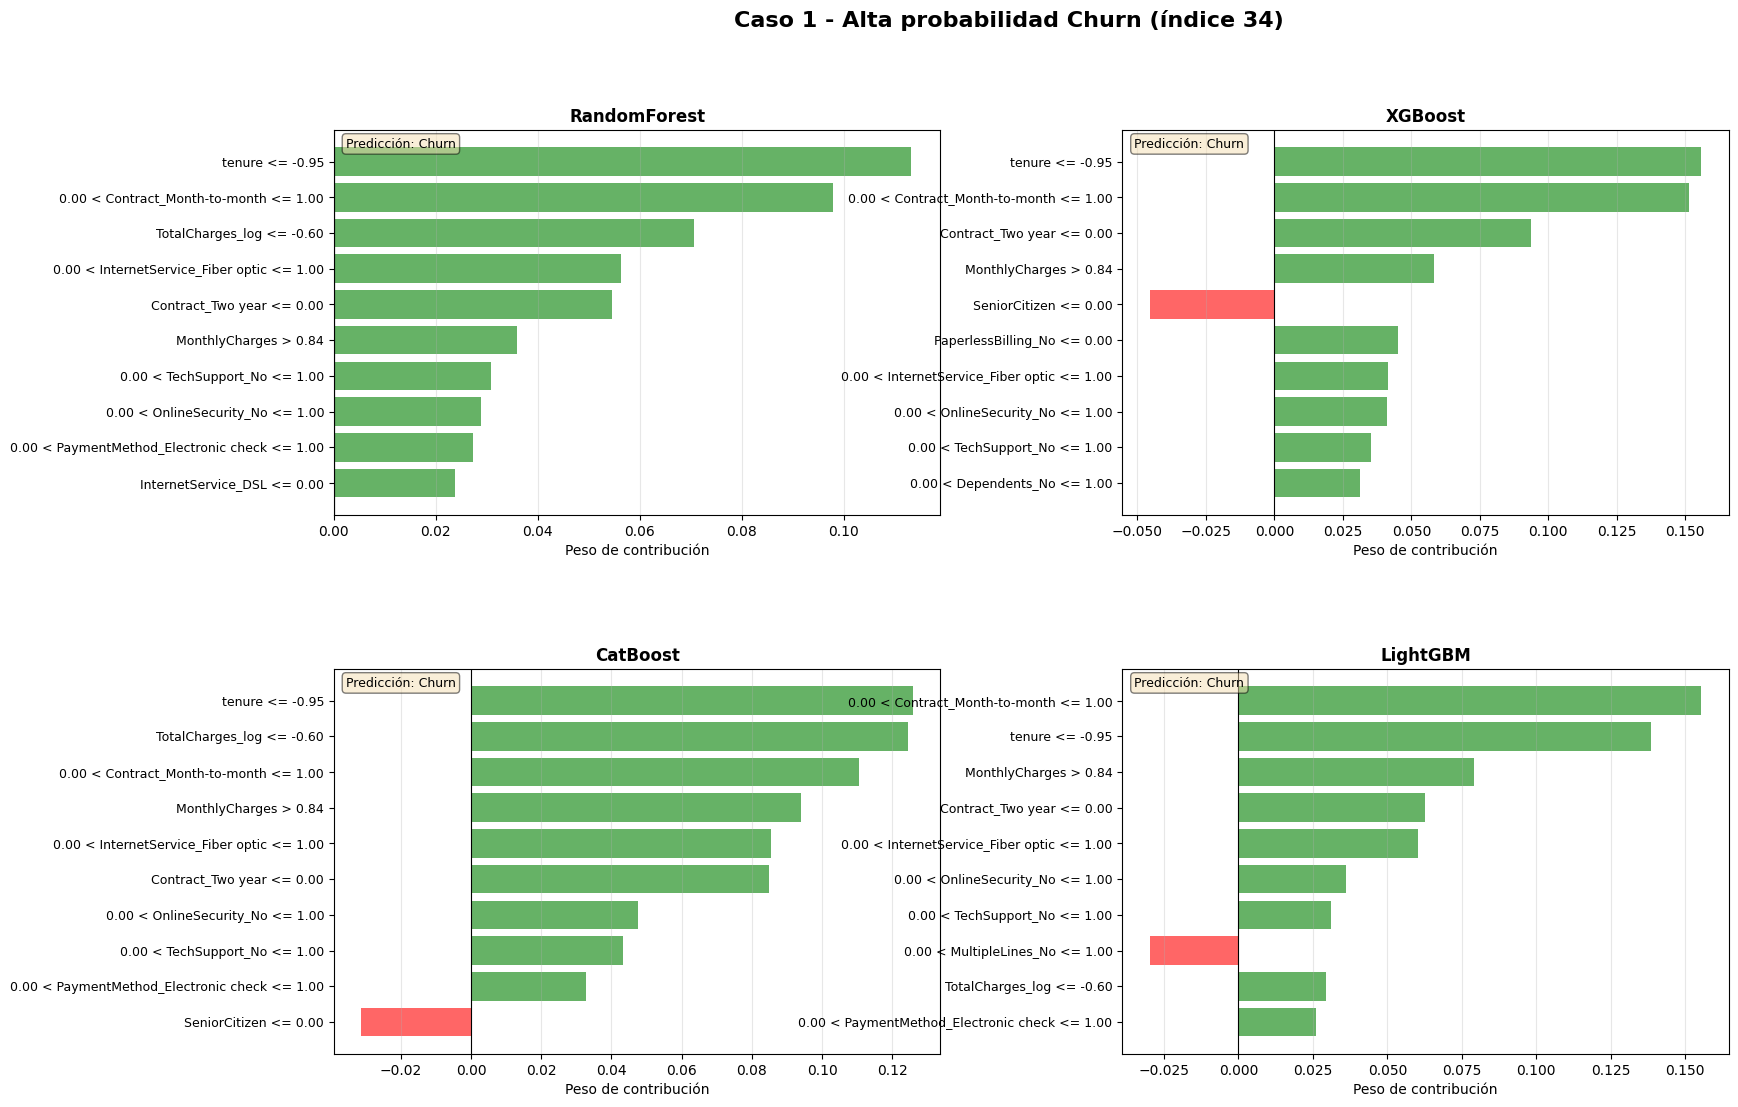

Visualizando: Caso 2 - Alta probabilidad No Churn
  Valor real: No Churn



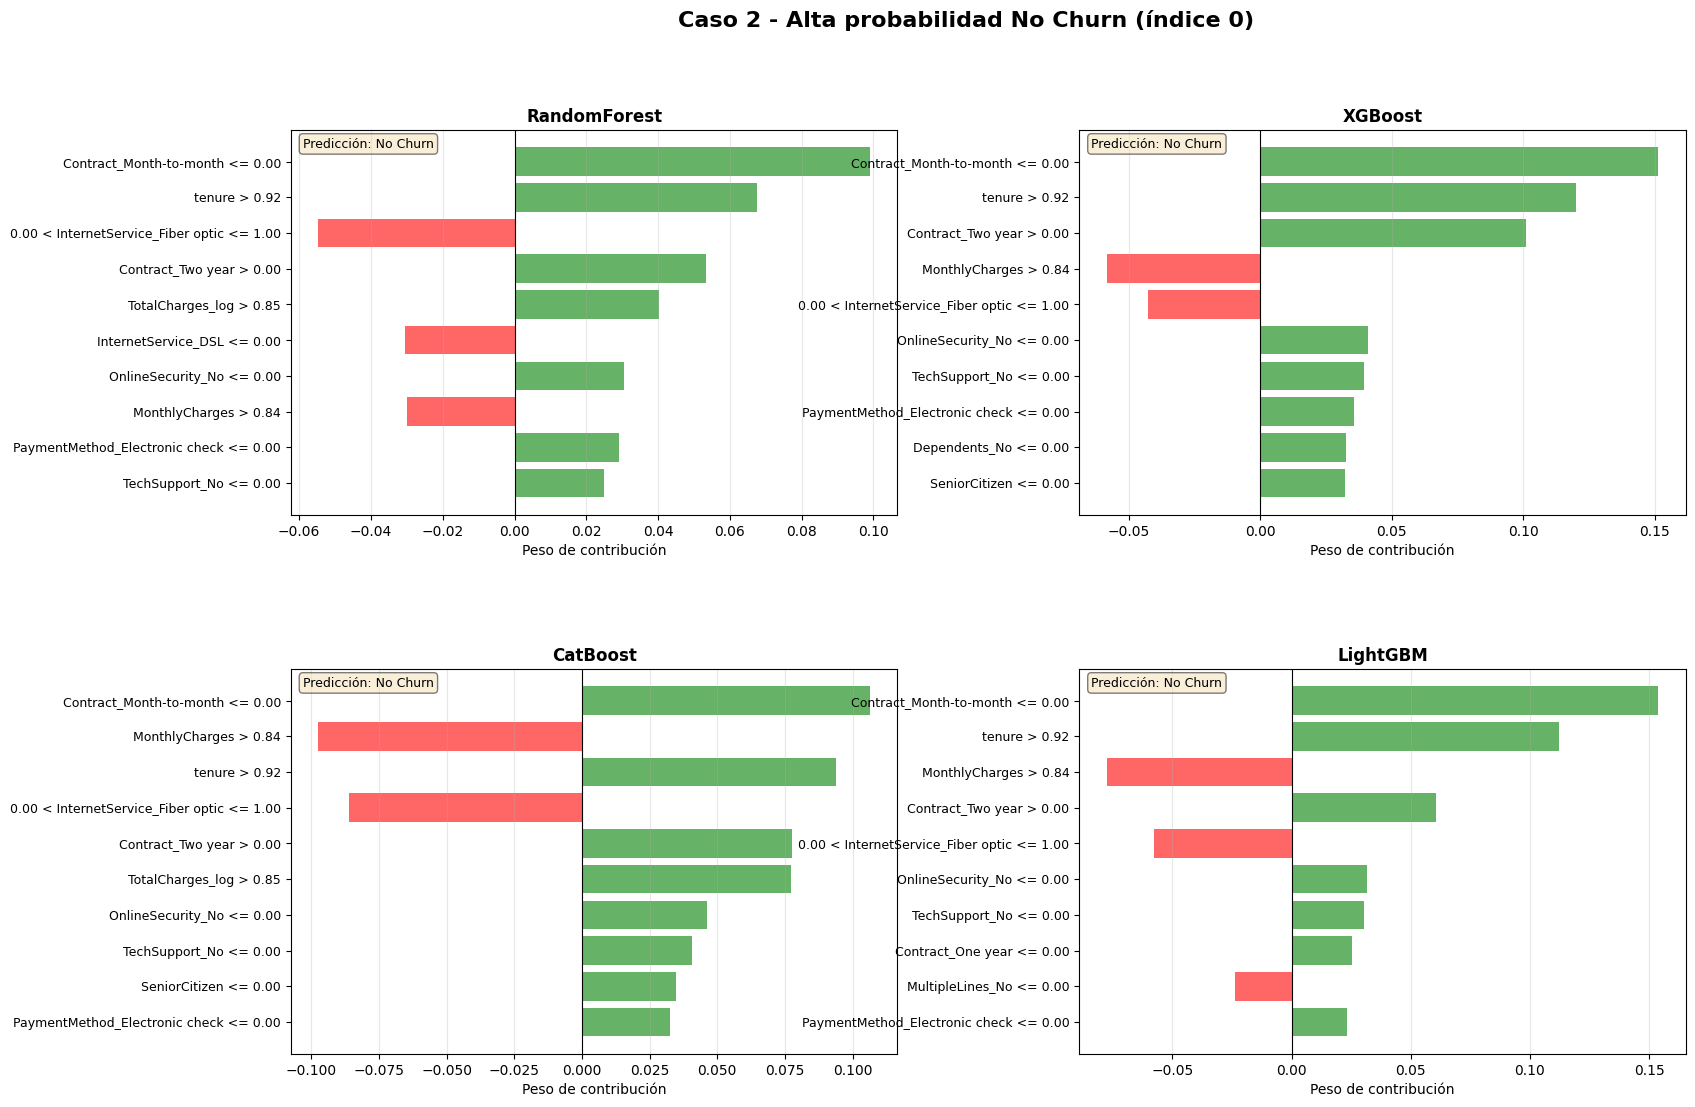

Visualizando: Caso 3 - Caso Ambiguo
  Valor real: Churn



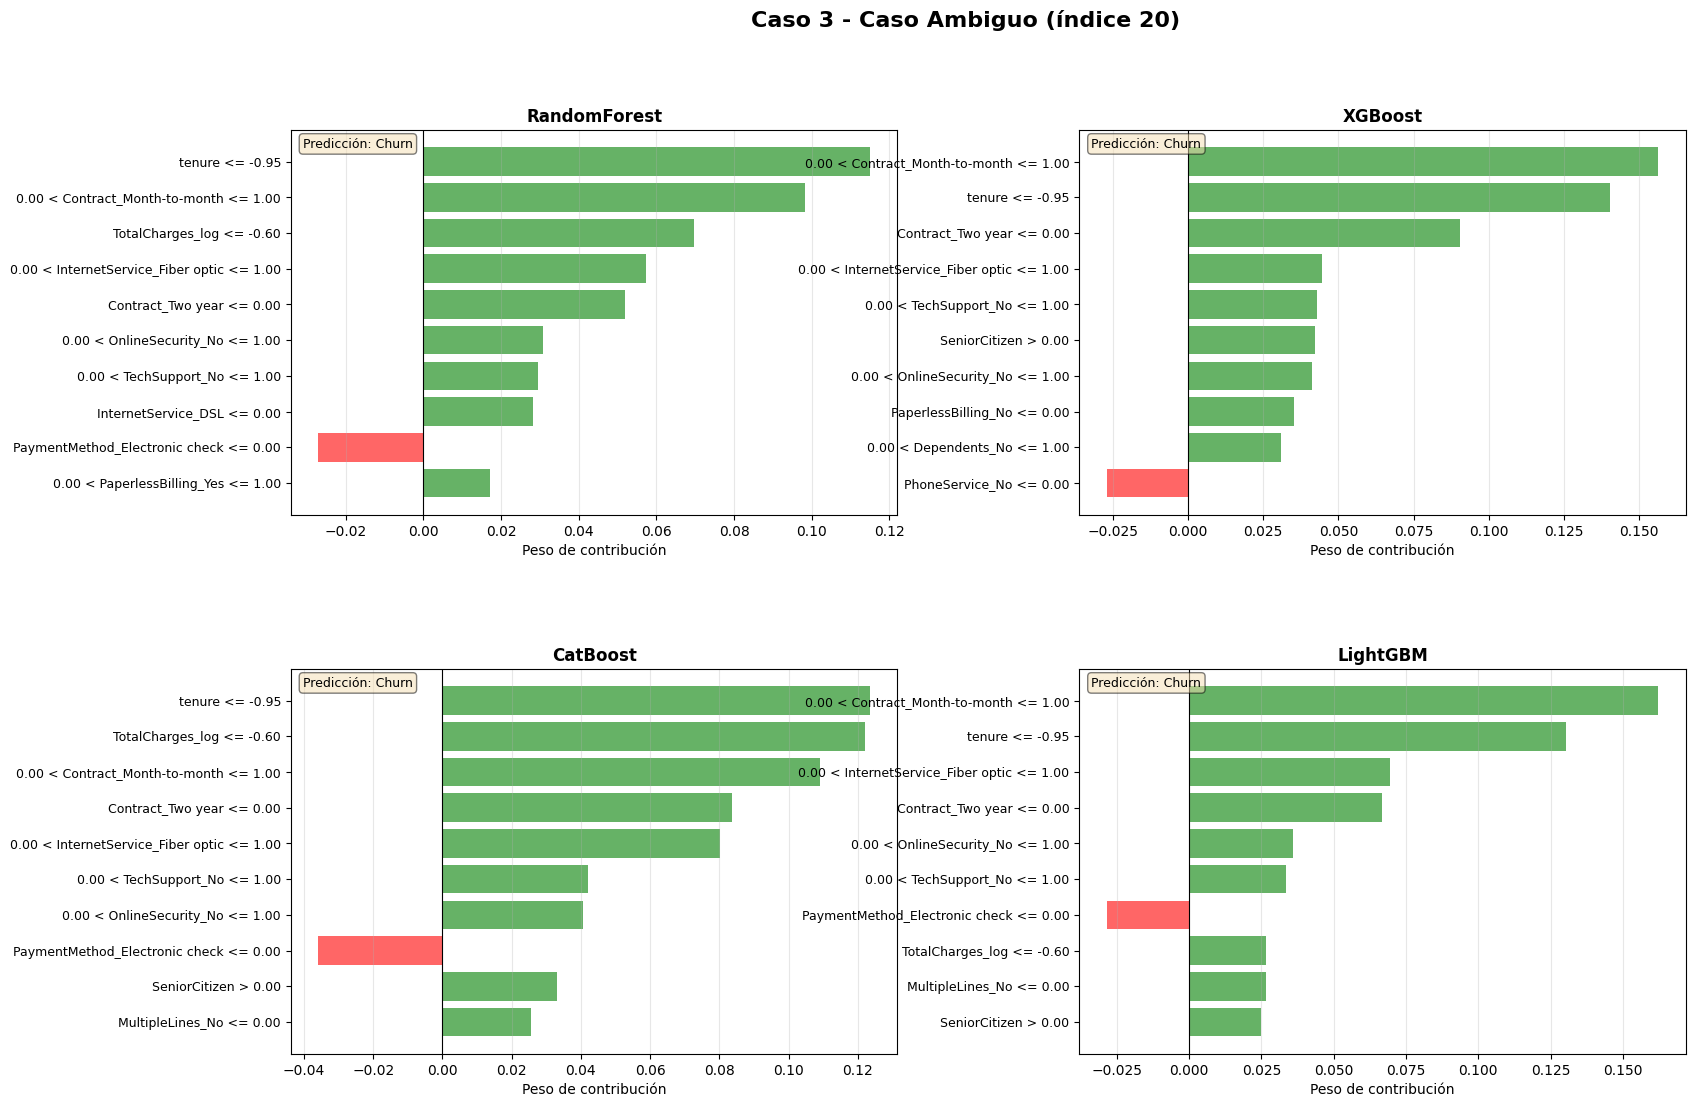


✓ Visualizaciones completadas


In [17]:
# Visualizar explicaciones LIME para cada caso
# Mostraremos los 4 modelos para cada caso en una cuadrícula 2x2

import matplotlib.pyplot as plt
from matplotlib import gridspec

def visualize_lime_explanations_for_case(case_desc, explanations_dict, case_idx):
    """
    Visualiza explicaciones LIME de los 4 modelos para un caso específico
    """
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle(f'{case_desc} (índice {case_idx})', fontsize=16, fontweight='bold')
    
    gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.3)
    
    model_names = list(explanations_dict.keys())
    positions = [(0,0), (0,1), (1,0), (1,1)]
    
    for (row, col), model_name in zip(positions, model_names):
        ax = fig.add_subplot(gs[row, col])
        exp = explanations_dict[model_name]
        
        # Obtener la predicción (label con mayor probabilidad)
        pred_class = exp.available_labels()[0]
        
        # Obtener features y sus pesos
        exp_list = exp.as_list(label=pred_class)
        features = [item[0] for item in exp_list]
        weights = [item[1] for item in exp_list]
        
        # Crear colores: positivo (apoya predicción) en verde, negativo en rojo
        colors = ['green' if w > 0 else 'red' for w in weights]
        
        # Crear gráfico de barras horizontal
        y_pos = np.arange(len(features))
        ax.barh(y_pos, weights, color=colors, alpha=0.6)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('Peso de contribución', fontsize=10)
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax.grid(axis='x', alpha=0.3)
        
        # Añadir predicción en el título
        pred_label = 'Churn' if pred_class == 1 else 'No Churn'
        ax.text(0.02, 0.98, f'Predicción: {pred_label}', 
                transform=ax.transAxes, fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.show()

# Visualizar cada uno de los 3 casos
print("Generando visualizaciones LIME...\n")

for case_desc, case_idx in selected_cases.items():
    print(f"Visualizando: {case_desc}")
    actual_label = 'Churn' if y_test.iloc[case_idx] == 1 else 'No Churn'
    print(f"  Valor real: {actual_label}\n")
    visualize_lime_explanations_for_case(case_desc, all_explanations[case_desc], case_idx)

print("\n✓ Visualizaciones completadas")

## Análisis de las Explicaciones


Analizando instancia personalizada: índice 100
Total de instancias en test: 1409

Valor real: Churn

Predicciones de los modelos:
  RandomForest: Churn      | P(Churn)=0.670
  XGBoost     : Churn      | P(Churn)=0.752
  CatBoost    : Churn      | P(Churn)=0.761
  LightGBM    : Churn      | P(Churn)=0.618

EXPLICACIONES LIME

RandomForest - Caso personalizado (índice 100)
Predicción: Churn
Probabilidades: No Churn=0.330, Churn=0.670

Top 10 features más influyentes:
  0.00 < Contract_Month-to-month <= 1.00                       | +0.0979 → Churn
  0.00 < InternetService_Fiber optic <= 1.00                   | +0.0539 → Churn
  Contract_Two year <= 0.00                                    | +0.0504 → Churn
  0.19 < TotalCharges_log <= 0.85                              | -0.0372 → No Churn
  MonthlyCharges > 0.84                                        | +0.0303 → Churn
  0.00 < OnlineSecurity_No <= 1.00                             | +0.0294 → Churn
  0.00 < PaymentMethod_Electronic check <

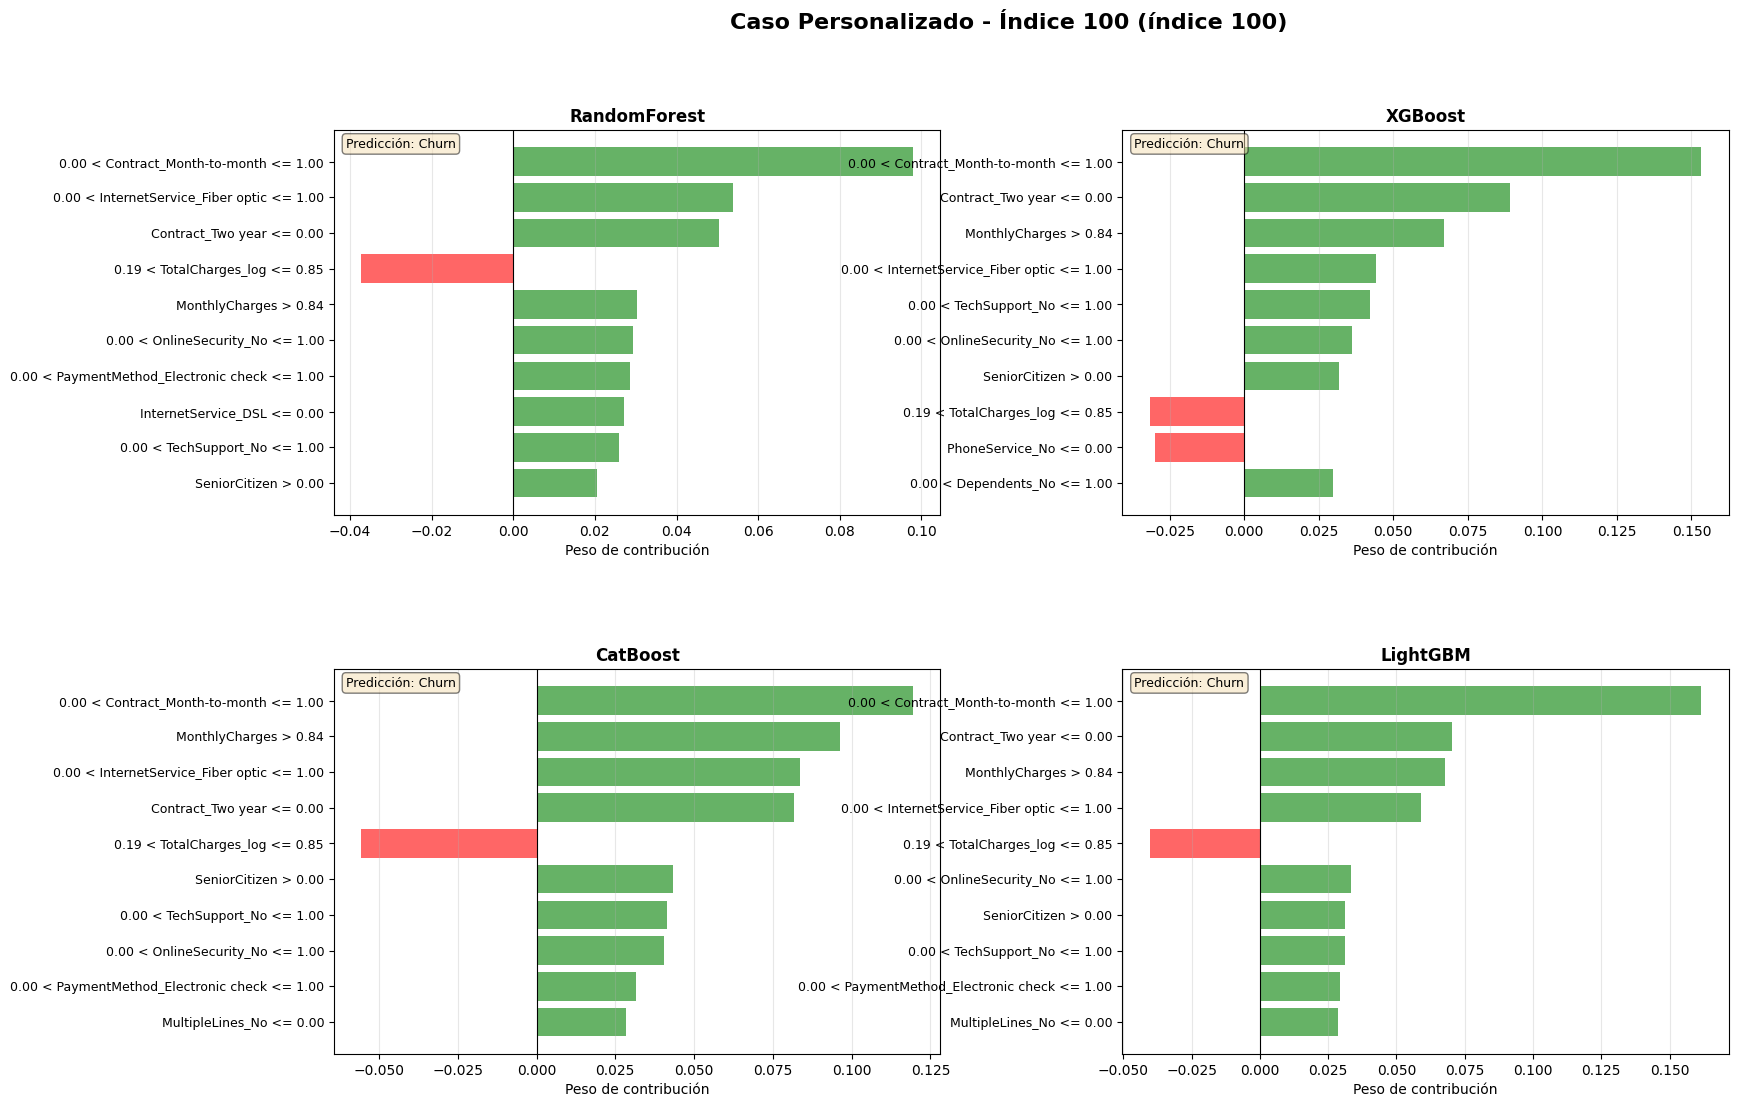

In [22]:
# Análisis de una instancia personalizada
custom_case_idx = 100  

print(f"Analizando instancia personalizada: índice {custom_case_idx}")
print(f"Total de instancias en test: {len(X_test)}\n")

# Verificar que el índice es válido
if custom_case_idx >= len(X_test):
    print(f"⚠️ Índice fuera de rango. Máximo: {len(X_test)-1}")
else:
    instance = X_test.iloc[custom_case_idx].values
    actual_label = 'Churn' if y_test.iloc[custom_case_idx] == 1 else 'No Churn'
    
    print(f"Valor real: {actual_label}\n")
    
    # Obtener predicciones de todos los modelos
    print("Predicciones de los modelos:")
    preds = get_predictions_info(fitted_models, instance)
    for model_name, info in preds.items():
        print(f"  {model_name:12s}: {info['prediction']:10s} | P(Churn)={info['proba_churn']:.3f}")
    
    # Generar explicaciones LIME para cada modelo
    print("\n" + "="*80)
    print("EXPLICACIONES LIME")
    print("="*80)
    
    custom_explanations = {}
    for model_name, model in fitted_models.items():
        exp = explain_instance_with_lime(
            explainer, 
            model, 
            instance, 
            model_name, 
            f"Caso personalizado (índice {custom_case_idx})",
            num_features=10
        )
        custom_explanations[model_name] = exp
    
    # Visualizar
    print("\n" + "="*80)
    print("VISUALIZACIÓN")
    print("="*80 + "\n")
    visualize_lime_explanations_for_case(
        f"Caso Personalizado - Índice {custom_case_idx}", 
        custom_explanations, 
        custom_case_idx
    )